## Cellpose trained to learn scale

This example shows how to train cellpose to find objects at different scales.  It is an iteration on a previous example which trained cellpose on a trivial image with one very small and one very large sphere.  This time we try to use the same cellpose model to detect several spheres of varying sizes in the same image. 

When applying a cellpose model to an image, it is common to use the 'diameter' parameter to rescale image to detect structure at a different scale than the network was trained for.  However this may not work if single images have objects at different scales within the image. 

If the training data has a mixture of small and large objects, cellpose can learn these.   This can be shown with a simple simulation.  

In [2]:
import raster_geometry as rg
import numpy as np
from tnia.simulation.phantoms import add_small_to_large_2d
import matplotlib.pyplot as plt
from tnia.plotting.plt_helper import imshow_multi2d, imshow2d
import math

## Make a super simple fake dataset

Here we add a few different objects of different sizes.

To create a training set we a keep a copy of the single spheres (which are put in 224 by 224 arrays by raster geometry... perfect for training patches)

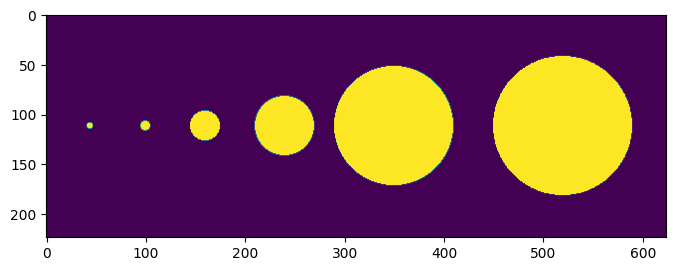

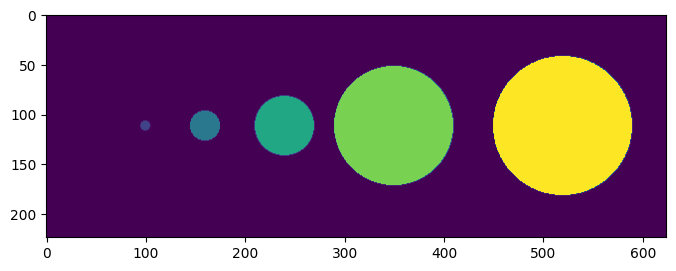

In [3]:
from sympy import im


width, height = 624, 224

image = np.zeros([height, width], dtype=np.float32)
truth = np.zeros([height, width], dtype=np.float32)

rs = [3, 5, 15, 30, 60, 70]

x_ = 44

# for train will be a list of the 224 by 224 circle images that will be used for training
for_train = []

i = 0
for r in rs:
    x, y = x_, 112
    size = [math.ceil(r*2), math.ceil(r*2)]
    size = [224, 224]
    temp=rg.circle(size, r)
    for_train.append(temp)
    add_small_to_large_2d(image, temp, x, y, mode='replace_non_zero')
    add_small_to_large_2d(truth, i*temp, x, y, mode='replace_non_zero')
    x_ = x_ + 50+2*r
    i += 1

fig = imshow2d(image)
fig = imshow2d(truth)

## Load Cyto2

We also print the mean diameter of cyto2 (if log is on this will print by default too)

In [15]:
from cellpose import models, io
model_cyto2 = models.CellposeModel(gpu=True, model_type="cyto2")
print('cyto2 diameter mean', model_cyto2.diam_labels)

2024-10-03 15:23:15,738 [INFO] >> cyto2 << model set to be used
2024-10-03 15:23:15,742 [INFO] ** TORCH CUDA version installed and working. **
2024-10-03 15:23:15,743 [INFO] >>>> using GPU
2024-10-03 15:23:16,128 [INFO] >>>> loading model C:\Users\bnort\.cellpose\models\cyto2torch_0
2024-10-03 15:23:16,267 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
cyto2 diameter mean 30.0


## Process with Cyto2 with different diameters 

We try a few different diameters to see if we can find all the objects. Unfortunately there is no diameter value that works for everything. 

It looks like d=6 finds the small objects, d=140 finds the big one, and default finds only a medium one. 

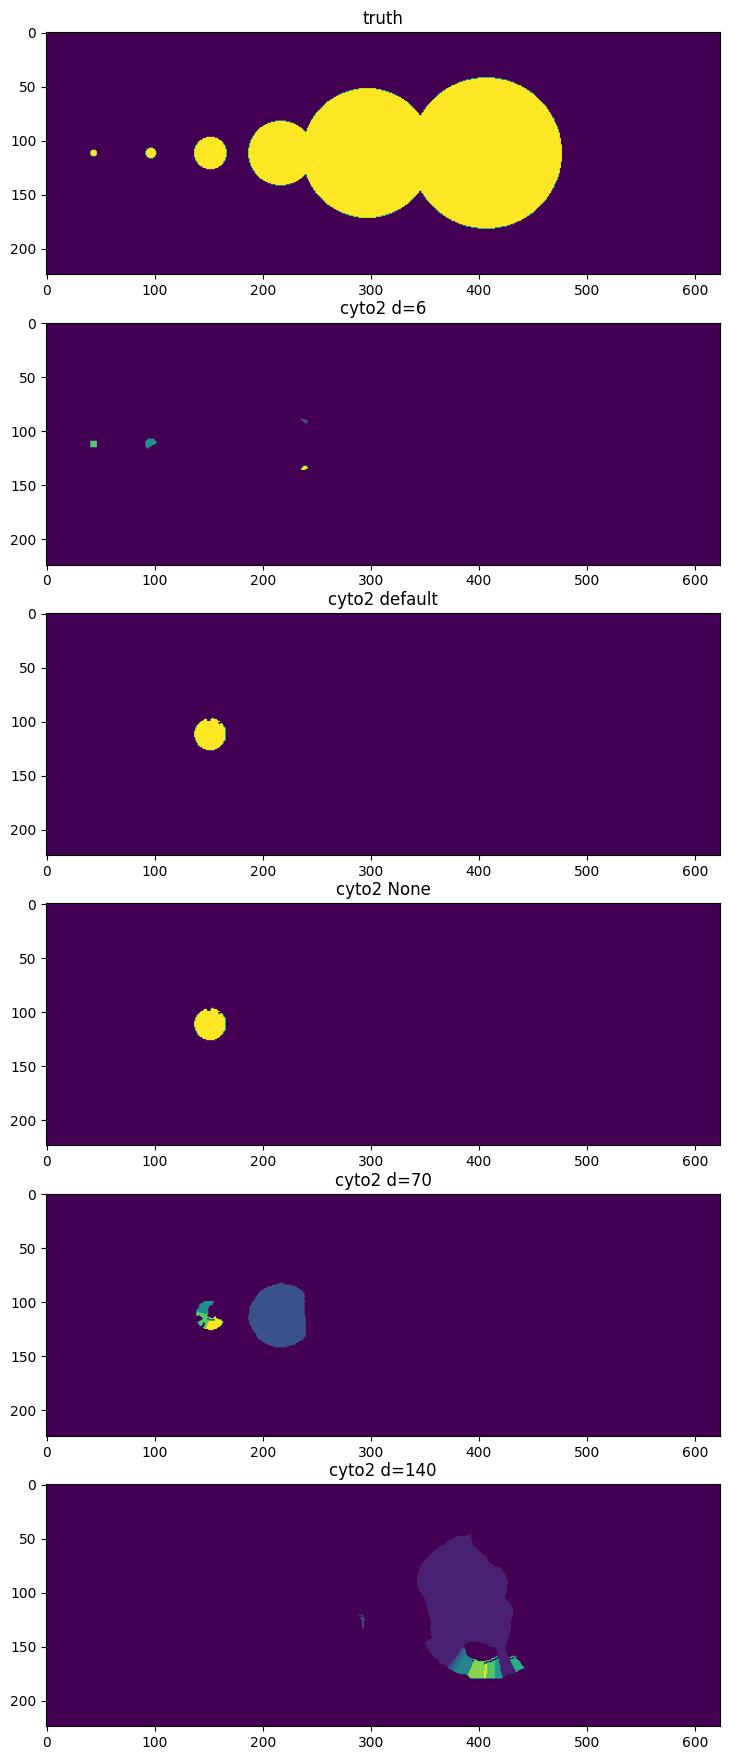

In [17]:

flow_threshold = 0
cellprob_threshold = -0.8

labels_d6 = model_cyto2.eval(image, channels=[0, 0],diameter=6,flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold)[0]
labels_default = model_cyto2.eval(image, channels=[0, 0], flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold)[0]
labels_none = model_cyto2.eval(image, channels=[0, 0], diameter = None, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold)[0]
labels_d70 = model_cyto2.eval(image, channels=[0, 0],diameter=70,flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold)[0]
labels_d140 = model_cyto2.eval(image, channels=[0, 0],diameter=140,flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold)[0]
fig = imshow_multi2d([image, labels_d6, labels_default, labels_none, labels_d70, labels_d140], ['truth', 'cyto2 d=6', 'cyto2 default', 'cyto2 None', 'cyto2 d=70','cyto2 d=140'], 6 ,1, width = 12, height = 22)



## Repeat the objects to make a fake training set

Just repeat a few times to make a trivial training set.  No need to even add blur or noise, we just want to see if a custom model can learn different scales. 

In [6]:
X = []
Y = []
for train in for_train:
    X = X+[train.copy().astype('float32')[..., np.newaxis] for i in range(10)]
    Y = Y+[train.copy().astype('uint16') for i in range(10)]

len(X)

60

## Make a custom model

In [7]:
import os

model_path = r'./'
model_name = 'custom'
logger = io.logger_setup()
model_custom = models.CellposeModel(gpu=True, model_type=None)#, pretrained_model=os.path.join(model_path,'models',model_name))

creating new log file
2024-10-03 15:13:47,566 [INFO] WRITING LOG OUTPUT TO C:\Users\bnort\.cellpose\run.log
2024-10-03 15:13:47,566 [INFO] 
cellpose version: 	3.0.9 
platform:       	win32 
python version: 	3.10.14 
torch version:  	2.2.2+cu118
2024-10-03 15:13:47,569 [INFO] ** TORCH CUDA version installed and working. **
2024-10-03 15:13:47,570 [INFO] >>>> using GPU
2024-10-03 15:13:47,644 [INFO] >>>> no model weights loaded


## Train our custom model

Note our fake training set was trivial, a set of images each containing single circle ranging from large circles to small.

However I found that in order to learn this very simple data, we need to explicitly set 'rescale' to False when training.

Otherwise the images are rescaled during the training process, and we don't actually learn the different scales. 

In [8]:
from cellpose import train

test=train.train_seg(model_custom.net, X, Y, 
    channels=[0,0], 
    save_path=model_path, 
    n_epochs=180,
    nimg_per_epoch=60,
    min_train_masks=1,
    normalize = False,
    rescale = False,  
    model_name=model_name)

2024-10-03 15:14:28,984 [INFO] computing flows for labels


100%|██████████| 60/60 [00:04<00:00, 14.89it/s]

2024-10-03 15:14:33,030 [INFO] >>> computing diameters



100%|██████████| 60/60 [00:00<00:00, 3305.94it/s]

2024-10-03 15:14:33,052 [INFO] >>> using channels [0, 0]
2024-10-03 15:14:33,066 [INFO] >>> n_epochs=180, n_train=60, n_test=None
2024-10-03 15:14:33,067 [INFO] >>> AdamW, learning_rate=0.00500, weight_decay=0.00001



c:\Users\bnort\miniconda3\envs\pytorch_and_SAM3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2024-10-03 15:14:34,514 [INFO] >>> saving model to models\custom
2024-10-03 15:14:35,802 [INFO] 0, train_loss=1.3933, test_loss=0.0000, LR=0.0000, time 1.29s
2024-10-03 15:14:40,070 [INFO] 5, train_loss=0.6541, test_loss=0.0000, LR=0.0028, time 5.55s
2024-10-03 15:14:44,499 [INFO] 10, train_loss=0.2443, test_loss=0.0000, LR=0.0050, time 9.99s
2024-10-03 15:14:53,143 [INFO] 20, train_loss=0.0723, test_loss=0.0000, LR=0.0050, time 18.63s
2024-10-03 15:15:02,233 [INFO] 30, train_loss=0.0398, test_loss=0.0000, LR=0.0050, time 27.72s
2024-10-03 15:15:11,545 [INFO] 40, train_loss=0.0208, test_loss=0.0000, LR=0.0050, time 37.03s
2024-10-03 15:15:21,669 [INFO] 50, train_loss=0.0859, test_loss=0.0000, LR=0.0050, time 47.15s
2024-10-03 15:15:30,829 [INFO] 60, train_loss=0.0255, test_loss=0.0000, LR=0.0050, time 56.32s
2024-10-03 15:15:39,422 [INFO] 70, train_loss=0.0139, test_loss=0.0000, LR=0.0050, time 64.91s
2024-10-03 15:15:48,155 [INFO] 80, train_loss=0.0120, test_loss=0.0000, LR=0.0050, ti

In [8]:
labels_custom, c, d = model_custom.eval(truth, channels=[0, 0])
truth.sum(), labels_custom.sum()

(30340.0, 49928)

In [10]:
import napari
viewer = napari.Viewer()
viewer.add_image(c[0])

<Image layer 'Image' at 0x211f499eef0>

## Show all the cyto labels and label custom

Note, cyto can only find objects of different sizes by tuning the ```diameter``` param.  Custom can find very different object sizes by default. 

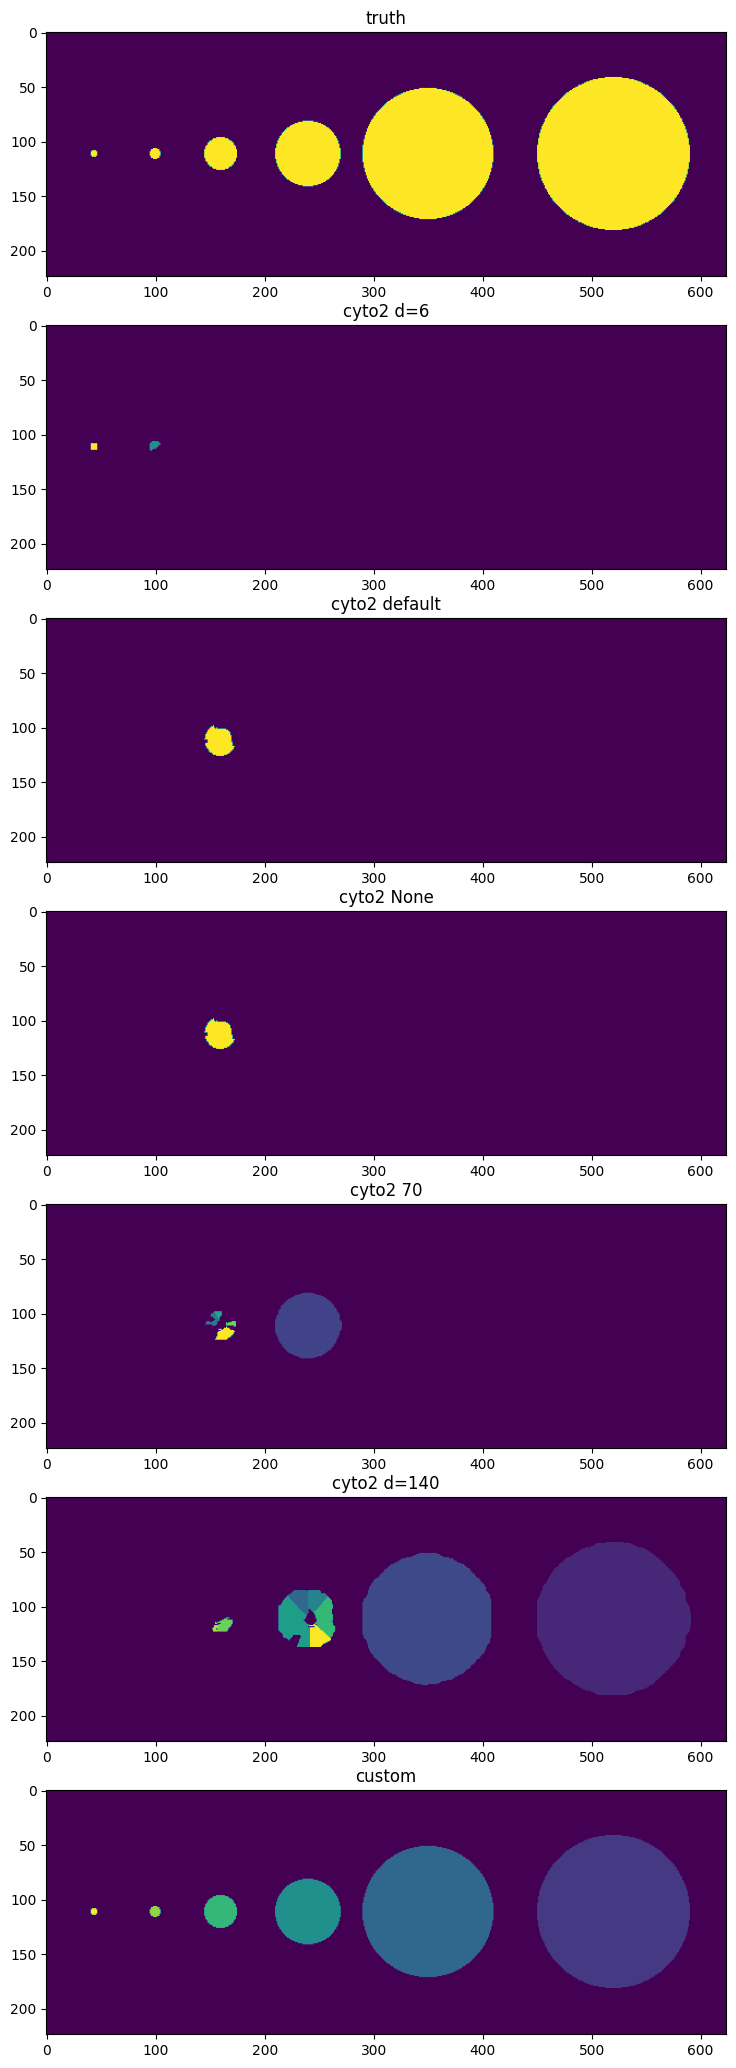

In [157]:
fig = imshow_multi2d([truth, labels_d6, labels_default, labels_none, labels_d70, labels_d140, labels_custom], ['truth', 'cyto2 d=6', 'cyto2 default', 'cyto2 None', 'cyto2 70', 'cyto2 d=140', 'custom'],7 ,1, width = 12, height = 26)

In [129]:
print(model_custom.diam_labels)
print(model_cyto2.diam_labels)

30.0
30.0
